In [ ]:
# Test File


In [21]:
########################################
#         Data Import from Sheets      #
########################################
import gspread
import pandas as pd
from datetime import datetime, timedelta
import calendar
import matplotlib.pyplot as plt
from oauth2client.service_account import ServiceAccountCredentials
import smtplib
from email.message import EmailMessage
import os
import mimetypes
from pathlib import Path
import json
from dotenv import load_dotenv

load_dotenv()

email_username = os.getenv("EMAIL_USERNAME")
email_password = os.getenv("EMAIL_PASSWORD")

# Set up credentials
scope = ['https://spreadsheets.google.com/feeds', 'https://www.googleapis.com/auth/drive']
# creds = ServiceAccountCredentials.from_json_keyfile_name(os.getenv('TRY'), scope)
json_keyfile_dict = json.loads(os.getenv("JSON_KEYFILE_DICT"))
creds = ServiceAccountCredentials.from_json_keyfile_dict(json_keyfile_dict, scope)
client = gspread.authorize(creds)


# Open Spreadsheet based on sheet key
spreadsheet_key = os.getenv("SPREADSHEET_KEY")
spreadsheet = client.open_by_key(spreadsheet_key)

## Open Expenses Sheet
sheet_title = 'Expenses'  
sheet = spreadsheet.worksheet(sheet_title)

# Extract all of the data
expenses_data = sheet.get_all_records()

# Convert from JSON to pandas Data Frame
expenses_data = pd.DataFrame(expenses_data)

# Make Timestamp a column that can be worked with Pandas library
expenses_data['Timestamp'] = pd.to_datetime(expenses_data['Timestamp'])

## Open Income Sheet
sheet_title = 'Income'  
sheet = spreadsheet.worksheet(sheet_title)

# Extract all of the data
income_data = sheet.get_all_records()

# Convert from JSON to pandas Data Frame
income_data = pd.DataFrame(income_data)

# Make Timestamp a column that can be worked with Pandas library
income_data['Timestamp'] = pd.to_datetime(income_data['Timestamp'])

In [29]:
# How much money have I spent since March 2023?
print(f"I have spent ${expenses_data['Expense Amount'].sum():,.2f} since March 2023")
print(f"I have earned ${income_data['Income Amount'].sum():,.2f} since March 2023")
print(f"In theory, I have saved ${income_data['Income Amount'].sum() - expenses_data['Expense Amount'].sum():,.2f}")


I have spent $62,328.24 since March 2023
I have earned $92,705.71 since March 2023
In theory, I have saved $30,377.47


In [ ]:
# Explanation of what is the numbers from my report
print("My expense report does not count my 401k at all")
print("My expense report does not count my earnings from ROTH IRA")
print("My expense report does not count my earnings from private investment account")
print("My expense report does not count my earnings from savings account")
print("My expense report does not count my cars asset")

print("My expense report includes the cash amount invested in ROTH IRA")
print("My expense report includes the cash amount invested in private investment account")
print("My expense report includes the cash amount in savings account")
print("My expense report includes the cash amount in checking account")
print("My expense report includes the cash amount in wallet")
print("My expense report includes the cash amount in venmo")

In [31]:
ROTH_IRA = 15778.64
Private_investment =10823.55
Four01k = 14822.28
Savings = 5514.06
Checking = 295.34
Wallet = 150
Venmo = 18.44
Cars = 16000

Capital_one_CC = 157.81
Citi_CC = 472.40

Net_worth = ROTH_IRA + Private_Investment + Four01k + Savings + Checking + Wallet + Venmo + Cars - Capital_one_CC - Citi_CC
Retirement_cash = ROTH_IRA + Four01k
Available_cash = Savings + Private_investment + Checking + Wallet + Venmo - Capital_one_CC - Citi_CC
Assets = Cars

In [32]:
# How my situation is right now (manual)
print('Positives:')
print(f"At the moment I have ${ROTH_IRA:,.2f} in my ROTH IRA")
print(f"At the moment I have ${Private_investment:,.2f} in my private investment account")
print(f"At the moment I have ${Savings:,.2f} in my 401k")
print(f"At the moment I have ${Savings:,.2f} in my savings account")
print(f"At the moment I have ${Checking:,.2f} in my checking account")
print(f"At the moment I have ${Wallet:,.2f} in my wallet")
print(f"At the moment I have ${Venmo:,.2f} in my venmo")
print(f"At the moment I have 2 cars worth total ${Cars:,.2f}\n")

print("Negatives:")
print(f"At the moment I have ${Capital_one_CC:,.2f} capital one credit card")
print(f"At the moment I have ${Citi_CC:,.2f} citi bank credit card\n")

print("Net Totals:")
print(f"I have in total ${Net_worth:,.2f} net worth\n")

print("Relevant Totals:")
print(f"I have a total ${Retirement_cash:,.2f} in retirement cash")
print(f"I have a total ${Available_cash:,.2f} in available cash")
print(f"I have a total ${Assets:,.2f} in assets\n")

Positives:
At the moment I have $15,778.64 in my ROTH IRA
At the moment I have $10,823.55 in my private investment account
At the moment I have $5,514.06 in my 401k
At the moment I have $5,514.06 in my savings account
At the moment I have $295.34 in my checking account
At the moment I have $150.00 in my wallet
At the moment I have $18.44 in my venmo
At the moment I have 2 cars worth total $16,000.00

Negatives:
At the moment I have $157.81 capital one credit card
At the moment I have $472.40 citi bank credit card

Net Totals:
I have in total $62,772.10 net worth

Relevant Totals:
I have a total $30,600.92 in retirement cash
I have a total $16,171.18 in available cash
I have a total $16,000.00 in assets



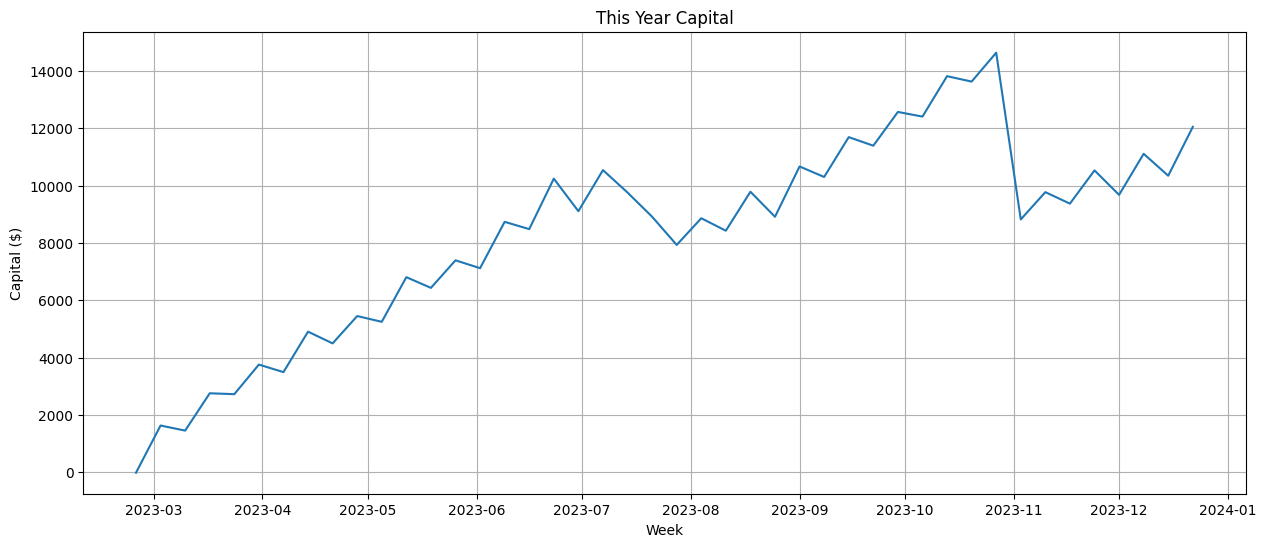

In [39]:
expenses_data['Income Amount'] = -expenses_data['Expense Amount']

# Make a simple line graph with This year actual income - actual expenses
stacked_actual_income_expenses = pd.concat([income_data[['Timestamp', 'Income Amount']], expenses_data[['Timestamp', 'Income Amount']]], axis=0, ignore_index=True)
stacked_actual_income_expenses = stacked_actual_income_expenses.sort_values(by='Timestamp')

# Filter for this year (not dinamic TO DO)
stacked_actual_income_expenses = stacked_actual_income_expenses[(stacked_actual_income_expenses['Timestamp'] <= '2023-12-31') & (stacked_actual_income_expenses['Timestamp'] > '2022-12-31')]

# Set the 'Date' column as the index
stacked_actual_income_expenses.set_index('Timestamp', inplace=True)

# Resample and sum by week (assuming week starts on Sunday)
this_year_weekly_expenses = stacked_actual_income_expenses
this_year_weekly_expenses = stacked_actual_income_expenses.resample('W-FRI').sum()
this_year_weekly_expenses['Actual'] = this_year_weekly_expenses['Income Amount'].cumsum()
#

# GRAPH
plt.figure(figsize=(15, 6))
plt.plot(this_year_weekly_expenses.index, this_year_weekly_expenses['Actual'])
plt.title('This Year Capital')
plt.xlabel('Week')
plt.ylabel('Capital ($)')
plt.grid(True)
plt.show()

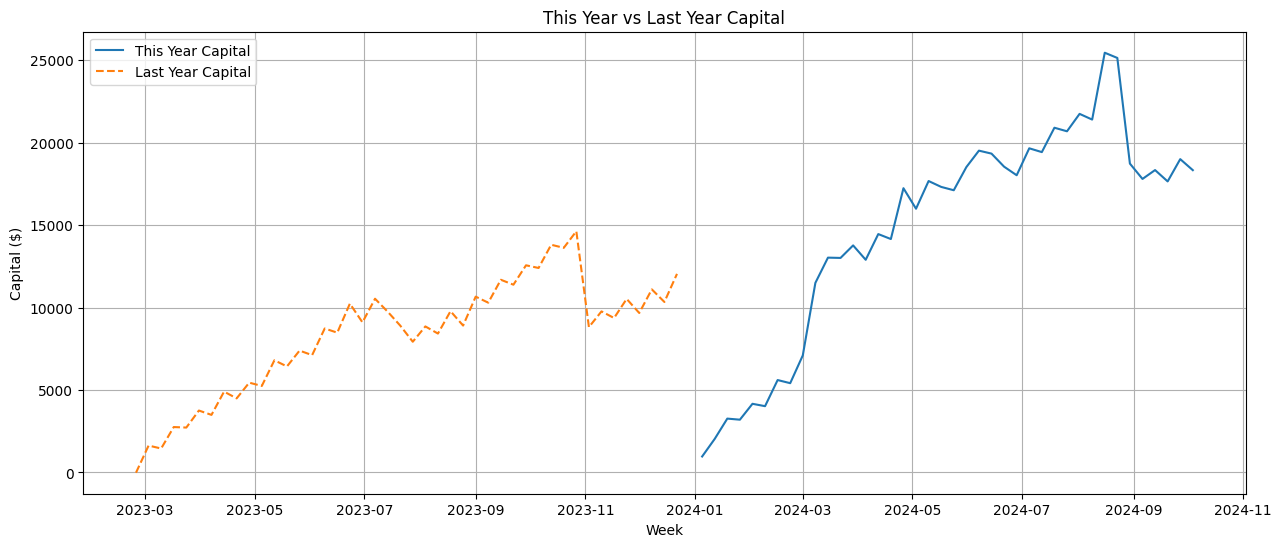

In [40]:
expenses_data['Income Amount'] = -expenses_data['Expense Amount']

# Income vs. Expenses for this year
stacked_actual_income_expenses = pd.concat([income_data[['Timestamp', 'Income Amount']], expenses_data[['Timestamp', 'Income Amount']]], axis=0, ignore_index=True)
stacked_actual_income_expenses = stacked_actual_income_expenses.sort_values(by='Timestamp')

# Filter for this year (not dynamic, TO DO)
stacked_actual_income_expenses_this_year = stacked_actual_income_expenses[stacked_actual_income_expenses['Timestamp'] > '2023-12-31']

# Set the 'Date' column as the index
stacked_actual_income_expenses_this_year.set_index('Timestamp', inplace=True)

# Resample and sum by week (assuming week starts on Sunday)
this_year_weekly_expenses = stacked_actual_income_expenses_this_year.resample('W-FRI').sum()
this_year_weekly_expenses['Actual'] = this_year_weekly_expenses['Income Amount'].cumsum()

# Filter for last year
stacked_actual_income_expenses_last_year = stacked_actual_income_expenses[(stacked_actual_income_expenses['Timestamp'] <= '2023-12-31') & (stacked_actual_income_expenses['Timestamp'] > '2022-12-31')]

# Set the 'Date' column as the index
stacked_actual_income_expenses_last_year.set_index('Timestamp', inplace=True)

# Resample and sum by week for last year
last_year_weekly_expenses = stacked_actual_income_expenses_last_year.resample('W-FRI').sum()
last_year_weekly_expenses['Actual'] = last_year_weekly_expenses['Income Amount'].cumsum()

# Plotting both years on the same graph
plt.figure(figsize=(15, 6))

# This year's data
plt.plot(this_year_weekly_expenses.index, this_year_weekly_expenses['Actual'], label='This Year Capital')

# Last year's data
plt.plot(last_year_weekly_expenses.index, last_year_weekly_expenses['Actual'], label='Last Year Capital', linestyle='--')

# Adding titles and labels
plt.title('This Year vs Last Year Capital')
plt.xlabel('Week')
plt.ylabel('Capital ($)')
plt.grid(True)
plt.legend()  # Display the legend to differentiate the lines

# Show the plot
plt.show()


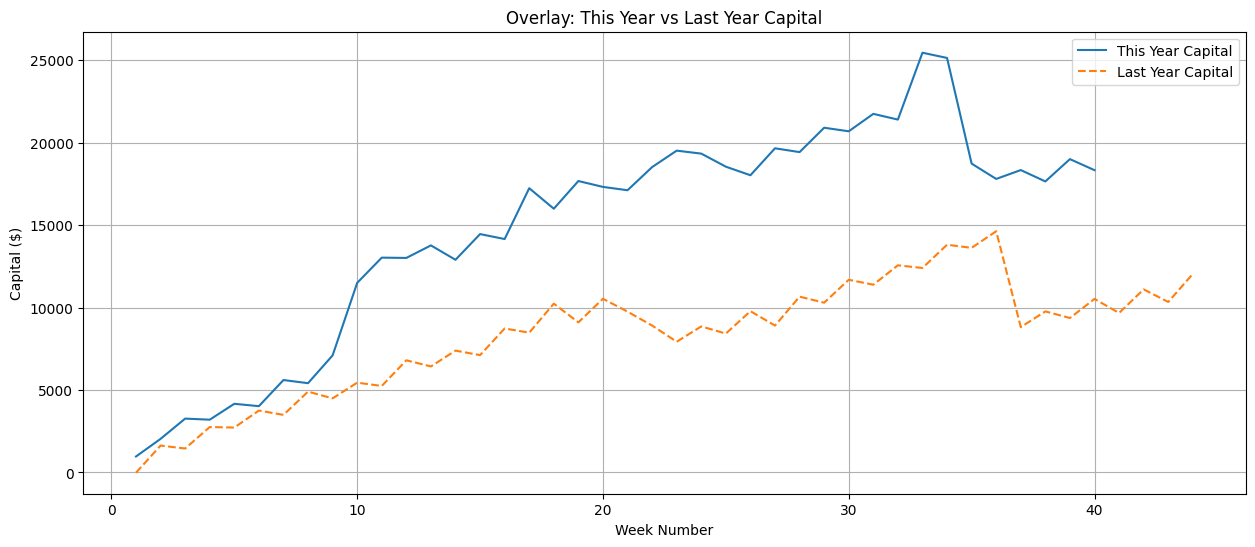

In [41]:
# Expenses data
expenses_data['Income Amount'] = -expenses_data['Expense Amount']

# Income vs. Expenses for this year
stacked_actual_income_expenses = pd.concat([income_data[['Timestamp', 'Income Amount']], expenses_data[['Timestamp', 'Income Amount']]], axis=0, ignore_index=True)
stacked_actual_income_expenses = stacked_actual_income_expenses.sort_values(by='Timestamp')

# Filter for this year (not dynamic, TO DO)
stacked_actual_income_expenses_this_year = stacked_actual_income_expenses[stacked_actual_income_expenses['Timestamp'] > '2023-12-31']

# Set the 'Date' column as the index
stacked_actual_income_expenses_this_year.set_index('Timestamp', inplace=True)

# Resample and sum by week (assuming week starts on Sunday)
this_year_weekly_expenses = stacked_actual_income_expenses_this_year.resample('W-FRI').sum()
this_year_weekly_expenses['Actual'] = this_year_weekly_expenses['Income Amount'].cumsum()

# Filter for last year
stacked_actual_income_expenses_last_year = stacked_actual_income_expenses[(stacked_actual_income_expenses['Timestamp'] <= '2023-12-31') & (stacked_actual_income_expenses['Timestamp'] > '2022-12-31')]

# Set the 'Date' column as the index
stacked_actual_income_expenses_last_year.set_index('Timestamp', inplace=True)

# Resample and sum by week for last year
last_year_weekly_expenses = stacked_actual_income_expenses_last_year.resample('W-FRI').sum()
last_year_weekly_expenses['Actual'] = last_year_weekly_expenses['Income Amount'].cumsum()

# Align both dataframes by resetting the index and setting "Week number" as index
# This step ensures we overlay the lines from the start of the year
this_year_weekly_expenses['Week_Number'] = range(1, len(this_year_weekly_expenses) + 1)
last_year_weekly_expenses['Week_Number'] = range(1, len(last_year_weekly_expenses) + 1)

# Plotting both years on the same graph, overlaying week by week
plt.figure(figsize=(15, 6))

# This year's data
plt.plot(this_year_weekly_expenses['Week_Number'], this_year_weekly_expenses['Actual'], label='This Year Capital')

# Last year's data
plt.plot(last_year_weekly_expenses['Week_Number'], last_year_weekly_expenses['Actual'], label='Last Year Capital', linestyle='--')

# Adding titles and labels
plt.title('Overlay: This Year vs Last Year Capital')
plt.xlabel('Week Number')
plt.ylabel('Capital ($)')
plt.grid(True)
plt.legend()  # Display the legend to differentiate the lines

# Show the plot
plt.show()

In [ ]:

# Add filter
expenses_data2 = expenses_data[expenses_data['Expense Type'] == 'Restaurant/Fast Food']

# Expenses data
expenses_data2['Expense Amount']

# Income vs. Expenses for this year
stacked_actual_income_expenses = pd.concat([income_data2[['Timestamp', 'Income Amount']], expenses_data2[['Timestamp', 'Income Amount']]], axis=0, ignore_index=True)
stacked_actual_income_expenses = stacked_actual_income_expenses.sort_values(by='Timestamp')

# Filter for this year (not dynamic, TO DO)
stacked_actual_income_expenses_this_year = stacked_actual_income_expenses[stacked_actual_income_expenses['Timestamp'] > '2023-12-31']

# Set the 'Date' column as the index
stacked_actual_income_expenses_this_year.set_index('Timestamp', inplace=True)

# Resample and sum by week (assuming week starts on Sunday)
this_year_weekly_expenses = stacked_actual_income_expenses_this_year.resample('W-FRI').sum()
this_year_weekly_expenses['Actual'] = this_year_weekly_expenses['Income Amount'].cumsum()

# Filter for last year
stacked_actual_income_expenses_last_year = stacked_actual_income_expenses[(stacked_actual_income_expenses['Timestamp'] <= '2023-12-31') & (stacked_actual_income_expenses['Timestamp'] > '2022-12-31')]

# Set the 'Date' column as the index
stacked_actual_income_expenses_last_year.set_index('Timestamp', inplace=True)

# Resample and sum by week for last year
last_year_weekly_expenses = stacked_actual_income_expenses_last_year.resample('W-FRI').sum()
last_year_weekly_expenses['Actual'] = last_year_weekly_expenses['Income Amount'].cumsum()

# Align both dataframes by resetting the index and setting "Week number" as index
# This step ensures we overlay the lines from the start of the year
this_year_weekly_expenses['Week_Number'] = range(1, len(this_year_weekly_expenses) + 1)
last_year_weekly_expenses['Week_Number'] = range(1, len(last_year_weekly_expenses) + 1)

# Plotting both years on the same graph, overlaying week by week
plt.figure(figsize=(15, 6))

# This year's data
plt.plot(this_year_weekly_expenses['Week_Number'], this_year_weekly_expenses['Actual'], label='This Year Capital')

# Last year's data
plt.plot(last_year_weekly_expenses['Week_Number'], last_year_weekly_expenses['Actual'], label='Last Year Capital', linestyle='--')

# Adding titles and labels
plt.title('Overlay: This Year vs Last Year Capital')
plt.xlabel('Week Number')
plt.ylabel('Capital ($)')
plt.grid(True)
plt.legend()  # Display the legend to differentiate the lines

# Show the plot
plt.show()